# Adversarial patch

This code creates an adversarial patch, which when placed on or near an object will disrupt the classification accuracy.

# Set up

First we import all the required packages. Here we will be using torch.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import json
import requests
from io import BytesIO
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We pull the image of my derpy Mileva mug from github, and transform the image into the right format for the model.

In [3]:
# Define the GitHub raw URL of your image
github_url = "https://raw.githubusercontent.com/harrietf/book/main/mug.jpg"  # You can also try adding your own

# Download the image from GitHub
response = requests.get(github_url)
if response.status_code == 200:
    input_image = Image.open(BytesIO(response.content)).convert("RGB")
else:
    raise Exception(f"Failed to download image, status code: {response.status_code}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Transform the input image
image = transform(input_image).unsqueeze(0)

We load our pre-trained model, MobilNetV2.

In [4]:
# Load a pre-trained model
model = models.mobilenet_v2(pretrained=True)
model.eval()

LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels = requests.get(LABELS_URL).text.splitlines()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 86.5MB/s]


In ImageNet a starfish has the label 327, so we include that here. We also define our patch size and a helper function to decode our predictions.

In [5]:
# Define patch size (e.g., 50x50 pixels)
patch_size = (3, 50, 50)  # 3 channels (RGB), height=50, width=50

# Initialize the patch randomly and ensure gradients can flow through it
patch = torch.rand(patch_size, requires_grad=True, device=device)

In [6]:
# Define the target class (e.g., "starfish")
target_class = 327  # Target class for adversarial patch (e.g., "starfish")

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([patch], lr=0.01)

# Function to decode predictions
def decode_predictions(logits, topk=1):
    with torch.no_grad():
        probabilities = nn.Softmax(dim=1)(logits)
        top_probs, top_idxs = probabilities.topk(topk, dim=1)
        return [labels[i.item()] for i in top_idxs[0]], top_probs[0].tolist()

We now generate the adversarial patch. We define our patch placement manually (x=100, y=100) but we could also create an optimization function to determine this placement based on the location that affects the classification confidence the most. The pixel values, like in PGD, are optimized the predict the target class.

In [7]:
num_iterations = 300
for iteration in range(num_iterations):
    optimizer.zero_grad()

    # Apply the patch to your base image clearly:
    patched_image = image.clone()
    patched_image[:, :, 100:150, 100:150] = patch  # top-left corner placement example

    # Forward pass clearly through your pretrained model:
    output = model(patched_image)

    # Calculate loss clearly against your target label:
    loss = criterion(output, torch.tensor([target_class], device=device))

    # Backpropagate clearly and update your patch
    loss.backward()
    optimizer.step()

    # Optional: Clip patch values to [0,1] clearly after each iteration
    with torch.no_grad():
        patch.clamp_(0, 1)

    if iteration % 50 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item():.4f}")


Iteration 0, Loss: 17.3461
Iteration 50, Loss: 2.9701
Iteration 100, Loss: 0.0242
Iteration 150, Loss: 0.0091
Iteration 200, Loss: 0.0061
Iteration 250, Loss: 0.0046


In [8]:
# Apply the final optimized patch
final_patched_image = image.clone()
final_patched_image[:, :, 100:150, 100:150] = patch.detach()

# Check the prediction clearly
model.eval()
with torch.no_grad():
    final_output = model(final_patched_image)
    final_probabilities = torch.softmax(final_output, dim=1)
    final_confidence, final_class = torch.max(final_probabilities, 1)

    print(f"Patched image predicted class: {final_class.item()}, confidence: {final_confidence.item():.4f}")

Patched image predicted class: 327, confidence: 0.9963


Now we display the original image and the patched image.

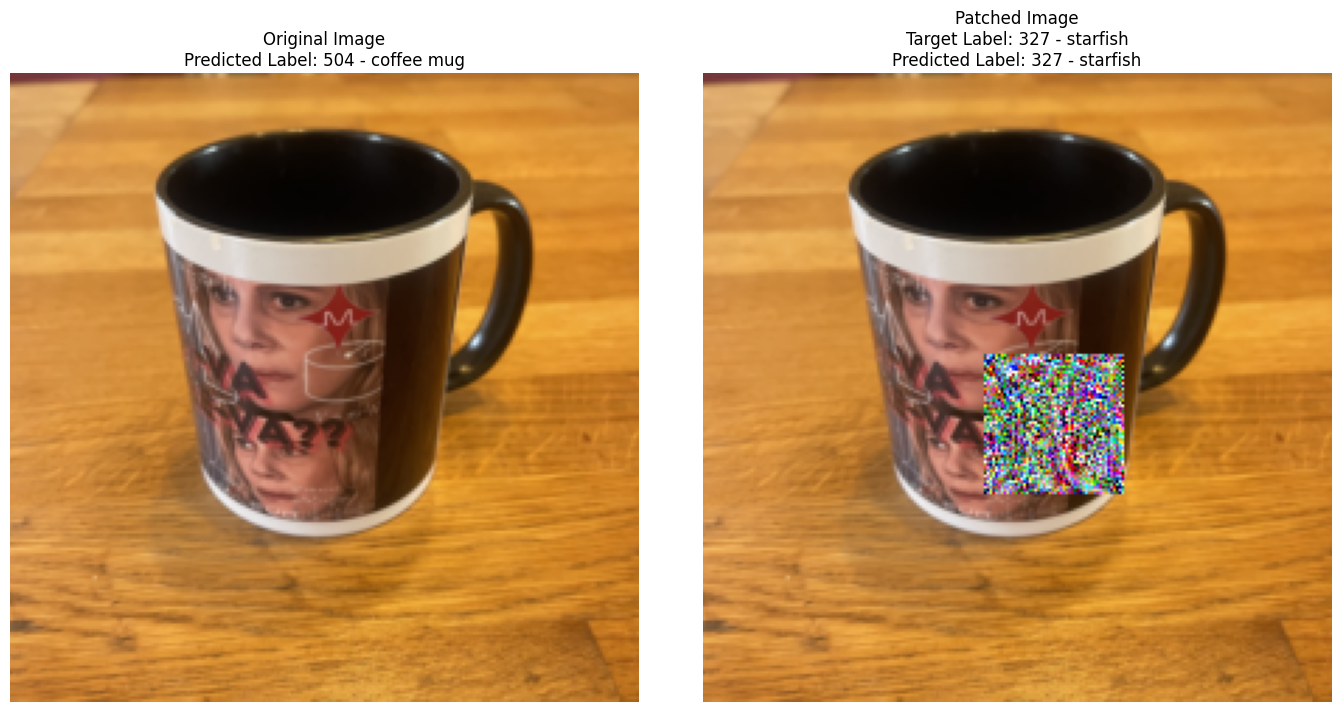

In [9]:
# Prepare images for visualization
original_img_to_show = image.squeeze(0).cpu()
patched_img_to_show = final_patched_image.squeeze(0).cpu()

original_pil = to_pil_image(original_img_to_show)
patched_pil = to_pil_image(patched_img_to_show)

# Get original model prediction clearly
model.eval()
with torch.no_grad():
    original_output = model(image)
    original_confidence, original_class = torch.max(torch.softmax(original_output, dim=1), 1)

    patched_output = model(final_patched_image)
    patched_confidence, patched_class = torch.max(torch.softmax(patched_output, dim=1), 1)

# Plot clearly side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Original Image with prediction
axes[0].imshow(original_pil)
axes[0].axis('off')
axes[0].set_title(f'Original Image\nPredicted Label: {original_class.item()} - {labels[original_class]}')

# Patched Image with adversarial prediction and target
axes[1].imshow(patched_pil)
axes[1].axis('off')
axes[1].set_title(f'Patched Image\nTarget Label: {target_class} - {labels[target_class]}\n'
                  f'Predicted Label: {patched_class.item()} - {labels[patched_class]}')

plt.tight_layout()
plt.show()
